In [1]:
# Need 70Gb memory to run this as peaks at just over 60gb RAM

In [2]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from useful_funcs import parse_data_dfs, make_timeseries
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import sys

di_df, pi_df, ti_df, dp_df, pp_df, tp_df = parse_data_dfs()
imperfect_final_rivs, perfect_final_rivs = list(di_df), list(dp_df)

print('Collected all base dataframes')
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

dtrain_df = di_df.loc[:, train_rivs]
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]

print('Transforming dataframes into timeseries dataframe')
data_days = 49
future_days = 14
rivers_to_consider = 1816  # up to 1816 rivers but will be slower


def slide_window_riv(riv):
    rolling_period = data_days+future_days
    imp = riv in list(di_df)
    d = di_df[riv].rolling(
        rolling_period) if imp else dp_df[riv].rolling(rolling_period)
    p = pi_df[riv].rolling(
        rolling_period) if imp else pp_df[riv].rolling(rolling_period)
    t = ti_df[riv].rolling(
        rolling_period) if imp else tp_df[riv].rolling(rolling_period)
    all_features = []

    # sliding window through depth, pressure and temp
    for idx, (rd, rp, rt) in enumerate(zip(d, p, t)):
        # rolling window initially not full
        if len(rd) != rolling_period:
            continue
        # https://stats.stackexchange.com/questions/35304/how-to-standardize-an-array-if-standard-deviation-is-zero
        rd_d = rd.values[:data_days]
        rd_m, rd_std = np.mean(rd_d), np.std(rd_d) if np.std(rd_d) != 0 else 1
        rp_d = rp.values[:data_days]
        rp_m, rp_std = np.mean(rp_d), np.std(rp_d) if np.std(rp_d) != 0 else 1
        rt_d = rt.values[:data_days]
        rt_m, rt_std = np.mean(rt_d), np.std(rt_d) if np.std(rt_d) != 0 else 1
        feature_data = np.concatenate(
            ((rd_d-rd_m)/rd_std, (rp_d-rp_m)/rp_std, (rt_d-rt_m)/rt_std))
        features = [(rd.values[-1]-rd_m)/rd_std, riv, idx] + list(feature_data)
        all_features.append(features)
    return all_features


all_rivs = list(di_df) + list(dp_df)
X_train_df, X_val_df, X_test_df = make_timeseries(
    all_rivs[:rivers_to_consider], train_rivs, validate_rivs, slide_window_riv, data_days)
X_train_df['year_sin'] = np.sin(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_train_df['year_cos'] = np.cos(
    X_train_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_sin'] = np.sin(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_val_df['year_cos'] = np.cos(X_val_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_sin'] = np.sin(X_test_df['river_day'] * (2 * np.pi / 365.2425))
X_test_df['year_cos'] = np.cos(X_test_df['river_day'] * (2 * np.pi / 365.2425))


2022-11-15 00:07:39.533209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 00:07:39.614533: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Collected all base dataframes
Transforming dataframes into timeseries dataframe


Reassigning river data to correct frame: 100%|██████████| 1816/1816 [01:02<00:00, 29.05it/s]


Training data made
Training data sorted
Validation data made
Validation data sorted
Test data made
Test data sorted


In [3]:
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

tot_size = sizeof_fmt(sum([sys.getsizeof(value) for name, value in globals().items()]))
print(f'Current total size of variables is {tot_size} ... who knows what rest is!')
# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

Current total size of variables is 8.0 GiB ... who knows what rest is!


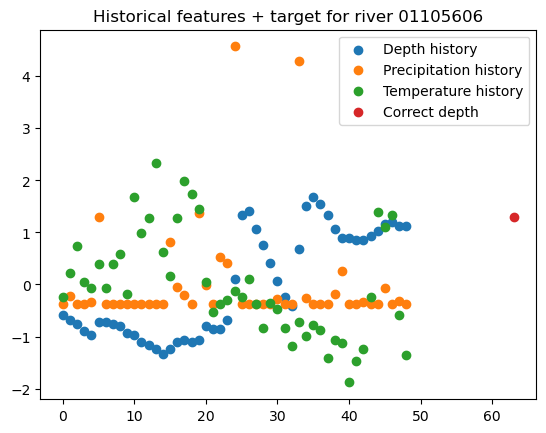

In [4]:
# What input and prediction looks like looks like
rowIdx = 42
y_point = X_train_df.iloc[rowIdx, :]['y']
all_ds = [f'd{idx}' for idx in range(data_days)]
all_ps = [f'p{idx}' for idx in range(data_days)]
all_ts = [f't{idx}' for idx in range(data_days)]
d_points = X_train_df.iloc[rowIdx, :][all_ds].to_list()
p_points = X_train_df.iloc[rowIdx, :][all_ps].to_list()
t_points = X_train_df.iloc[rowIdx, :][all_ts].to_list()
plt.scatter(range(data_days), d_points, label='Depth history')
plt.scatter(range(data_days), p_points, label='Precipitation history')
plt.scatter(range(data_days), t_points, label='Temperature history')
plt.scatter(data_days + future_days, y_point, label='Correct depth')
plt.legend()
riv_name = X_train_df.iloc[rowIdx, :]['river']
plt.title(f'Historical features + target for river {riv_name}')
plt.show()


In [5]:
# Baseline model
model = Sequential([
    Dense(1, input_shape=np.array(X_val_df.columns[3:]).shape)
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x=X_train_df.iloc[:, 3:], y=X_train_df.iloc[:, 0], epochs=100,
                    batch_size=10000,
                    validation_split=0.2)


2022-11-15 00:21:05.528476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tmd4/.conda/envs/mlwaterlevel/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
343/343 [==============================] - 3s 6ms/step - loss: 2006421067219438917872779264.0000 - mean_absolute_error: 138689069056.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 2/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420624497581148843540480.0000 - mean_absolute_error: 138689101824.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 3/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420624497581148843540480.0000 - mean_absolute_error: 138689069056.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 4/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420476923628559167127552.0000 - mean_absolute_error: 138689052672.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 5/100
343/343 [===

343/343 [==============================] - 1s 2ms/step - loss: 2006420476923628559167127552.0000 - mean_absolute_error: 138689052672.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 35/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420919645486328196366336.0000 - mean_absolute_error: 138689069056.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 36/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420624497581148843540480.0000 - mean_absolute_error: 138689069056.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 37/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420181775723379814301696.0000 - mean_absolute_error: 138689085440.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 38/100
343/343 [===========

343/343 [==============================] - 1s 2ms/step - loss: 2006420919645486328196366336.0000 - mean_absolute_error: 138689085440.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 68/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420919645486328196366336.0000 - mean_absolute_error: 138688970752.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 69/100
343/343 [==============================] - 1s 2ms/step - loss: 2006420624497581148843540480.0000 - mean_absolute_error: 138689134592.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 70/100
343/343 [==============================] - 1s 2ms/step - loss: 2006421214793391507549192192.0000 - mean_absolute_error: 138689069056.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000
Epoch 71/100
343/343 [===========

343/343 [==============================] - 1s 2ms/step - loss: 2006421214793391507549192192.0000 - mean_absolute_error: 138689085440.0000 - val_loss: 721363089807363917888561872896.0000 - val_mean_absolute_error: 5637167644672.0000


Really poor performance


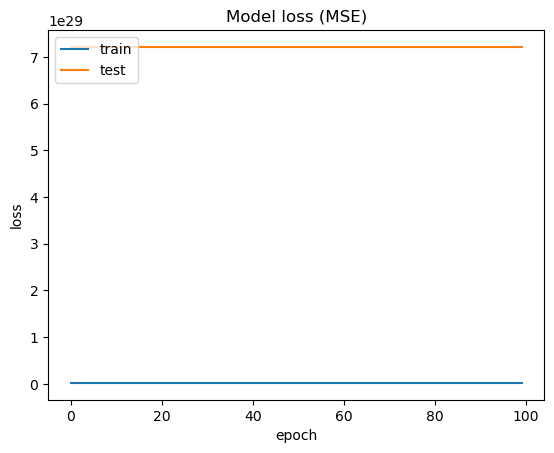

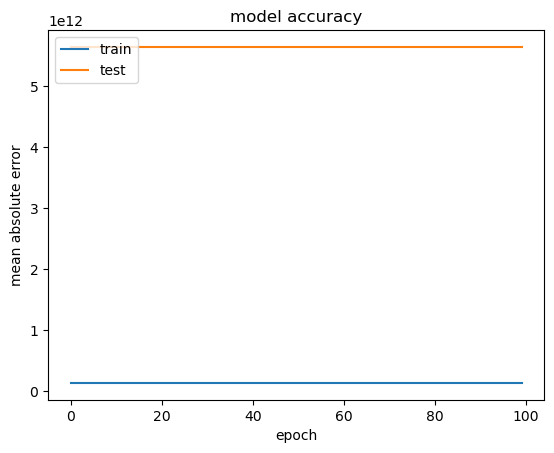

In [6]:
print('Really poor performance')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


133802/133802 [==============================] - 54s 405us/step


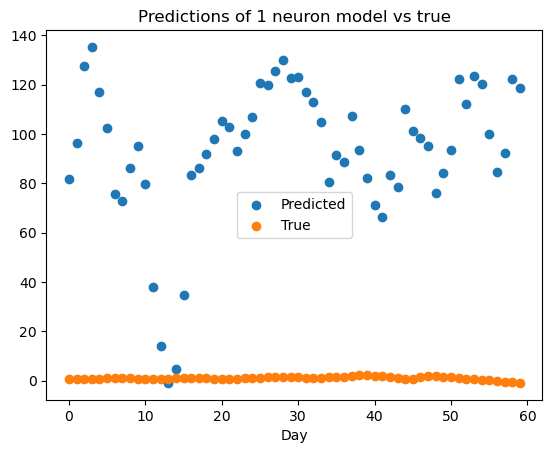

In [12]:
points = 60
df = X_train_df
predictions = model.predict(x=df.iloc[:, 3:]).reshape(-1)[:points]
true_vals = df.iloc[:points, 0]
plt.scatter(range(points), predictions, label="Predicted")
plt.scatter(range(points), true_vals, label="True")
plt.legend()
plt.title('Predictions of 1 neuron model vs true')
plt.xlabel('Day')
plt.show()

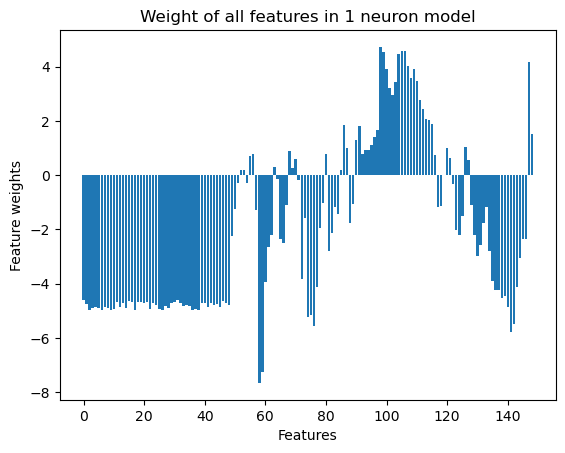

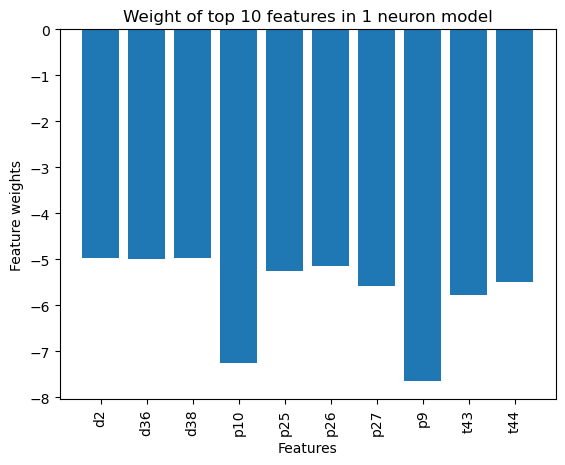

In [8]:
# based on https://www.tensorflow.org/tutorials/structured_data/time_series
cols = list(X_val_df)[3:]
plt.bar(x=range(len(cols)),
        height=model.layers[0].kernel[:, 0].numpy())
plt.title('Weight of all features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()

# top 10 features
top_num = 10
basic_coef_ord = np.argsort(np.absolute(model.layers[0].kernel[:, 0].numpy()))
new_cols = []
for idx in basic_coef_ord[-top_num:][::-1]:
    col_name = cols[idx]
    col_val = model.layers[0].kernel[:, 0].numpy()[idx]
    new_cols.append((col_name, col_val))
new_cols.sort(key=lambda x: x[0])
plt.bar(x=range(top_num),
        height=[b for a, b in new_cols])
axis = plt.gca()
axis.set_xticks(range(top_num))
_ = axis.set_xticklabels([a for a, b in new_cols], rotation=90)
plt.title(f'Weight of top {top_num} features in 1 neuron model')
plt.ylabel('Feature weights')
plt.xlabel('Features')
plt.show()


In [15]:
gc.collect()

0

In [9]:
model = Sequential([
    # dense layer 1
    tf.keras.layers.Conv1D(32, 4, activation='relu',input_shape=np.array(X_val_df.columns[3:]).shape),
    Dense(units=32, activation='relu'),
    Dense(1)
])


ValueError: Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 149)